# Using AMASS for training DNNs for Human Body and Motion
AMASS is a large database of human bodies, ready to enable proper deep learning on human body. Instead of images, as in [ImageNet](http://www.image-net.org/),
 AMASS consists of human body parameters, controlling the surface mesh of the [SMPL](http://smpl.is.tue.mpg.de/) body model family.

Here we provide basic tools to turn AMASS bodies into suitable formats for deep learning frameworks.
We produce PyTorch readable *.pt*, as well as *.h5* files.

The provided data preparation code has three stages that could be flexibly customized to your own specific needs.

**Stage I** goes over the previously downloaded numpy npz files, sub-samples the time-length and dumps the result into one place as PyTorch pt files.

**Stage II** uses PyTorch to apply all sorts of data augmentations in parallel on the original data and produces HDF5 files.
HDF5 makes it possible to write files in chunks to avoid memory shortage,
while PyTorch speeds up data augmentation though batch processing .

**Stage III** simply turns the h5 files into pt files again to be readily usable by PyTorch.
One can replace this stage's output to any other suitable kind.

The progress at all stages is logged and could be inspected at any time during the process or later.
We suggest using an experiment ID that would help in referring to a specific, traceable, data preparation run.

Dependencies to run this notebook:
- [Human Body Prior](https://github.com/nghorbani/human_body_prior)
- [PyTorch>=1.7.0](https://pytorch.org/)
- [PyTables](https://www.pytables.org/usersguide/installation.html)
- [tqdm](https://pypi.org/project/tqdm/2.2.3/)

Before you continue with this tutorial, it is recommended to first take a look at the [**AMASS Visualization**](01-AMASS_Visualization.ipynb) notebook.

In [1]:
# Preparing the environment
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

import os
from os import path as osp

import numpy as np
import torch

support_dir = '../support_data/'

In [2]:
# Choose the device to run the body model on.
comp_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from human_body_prior.tools.omni_tools import log2file, makepath
from human_body_prior.tools.omni_tools import copy2cpu as c2c

We first pick an experiment ID that later helps us to identify the specific run of data preparation and augmentations.
We also prepare a message about this specific experiment, that is going to be included in our log file as future notes.

In [4]:
expr_code = 'VXX_SVXX_TXX' #VERSION_SUBVERSION_TRY

msg = ''' Initial use of standard AMASS dataset preparation pipeline '''

Then you have to download the body npz files from [AMASS](https://amass.is.tue.mpg.de/).
You would need to first register and agree to the license and pick the subsets you like from datasets.
Uncompress the body data at your desired location. The final folder structure should be like the following:

**amass_dir>sub_dataset>subjects>*_poses.npz**

Now specify the directory of the downloaded npz files and the final output folder for the prepared data, e.g. **work_dir**.
At this location at each stage of the data processing pipeline, an appropriate folder is created.
Moreover, the log file, and a snapshot of the code is created.

In [5]:
amass_dir =  '../support_data/amass_npz' #'PATH_TO_DOWNLOADED_NPZFILES/*/*_poses.npz'

work_dir = '../support_data/prepared_data/VXX_SVXX_TXX'

logger = log2file(makepath(work_dir, '%s.log' % (expr_code), isfile=True))
logger('[%s] AMASS Data Preparation Began.'%expr_code)
logger(msg)

[VXX_SVXX_TXX] AMASS Data Preparation Began.
 Initial use of standard AMASS dataset preparation pipeline 


Now we have to specify data splits for train/validation/test. Below is the recommended data splits by AMASS
for train/validation/test that chooses data for each split from non-overlapping datasets. 
One reason is to avoid similarity of marker layouts used for the original data.
Remember, AMASS is growing, and it is a good idea to check the website for new datasets.
You can also follow [AMASS twitter](https://twitter.com/mocap_amass) account for news.

In [6]:
# amass_splits = {
#     'vald': ['HumanEva', 'MPI_HDM05', 'SFU', 'MPI_mosh'],
#     'test': ['Transitions_mocap', 'SSM_synced'],
#     'train': ['CMU', 'MPI_Limits', 'TotalCapture', 'Eyes_Japan_Dataset', 'KIT',
#               'BML', 'EKUT', 'TCD_handMocap', 'ACCAD']
# }
amass_splits = {
    'vald': ['SFU',],
    'test': ['SSM_synced'],
    'train': ['MPI_Limits']
}
amass_splits['train'] = list(set(amass_splits['train']).difference(set(amass_splits['test'] + amass_splits['vald'])))

Now we have everything in place to run the preparation code.
Take a look at the code for **prepare_amass** and customize it to your need.

In [7]:
from amass.data.prepare_data import prepare_amass
prepare_amass(amass_splits, amass_dir, work_dir, logger=logger)

Stage I: Fetch data from AMASS npz files
Stage II: augment the data and save into h5 files to be used in a cross framework scenario.

Stage III: dump every data field for all the splits as final pytorch pt files
Dumped final pytorch dataset at ../support_data/prepared_data/VXX_SVXX_TXX/stage_III


## Visualize the prepared data
Now we can try to open them with PyTorch which a dataloader:

In [8]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import glob 

class AMASS_DS(Dataset):
    """AMASS: a pytorch loader for unified human motion capture dataset. http://amass.is.tue.mpg.de/"""

    def __init__(self, dataset_dir, num_betas=16):

        self.ds = {}
        for data_fname in glob.glob(os.path.join(dataset_dir, '*.pt')):
            k = os.path.basename(data_fname).replace('.pt','')
            self.ds[k] = torch.load(data_fname)
        self.num_betas = num_betas

    def __len__(self):
       return len(self.ds['trans'])

    def __getitem__(self, idx):
        data =  {k: self.ds[k][idx] for k in self.ds.keys()}
        data['root_orient'] = data['pose'][:3]
        data['pose_body'] = data['pose'][3:66]
        data['pose_hand'] = data['pose'][66:]
        data['betas'] = data['betas'][:self.num_betas]

        return data

num_betas = 16 # number of body parameters
testsplit_dir = os.path.join(work_dir, 'stage_III', 'test')

ds = AMASS_DS(dataset_dir=testsplit_dir, num_betas=num_betas)
print('Test split has %d datapoints.'%len(ds))

batch_size = 5
dataloader = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=5)

Test split has 56 datapoints.


We can use the tutorial in [**AMASS Visualization**](01-AMASS_Visualization.ipynb) to visualize the data

In [9]:
import trimesh
from body_visualizer.tools.vis_tools import colors, imagearray2file
from body_visualizer.mesh.mesh_viewer import MeshViewer
from body_visualizer.tools.vis_tools import show_image

imw, imh = 1600, 1600
mv = MeshViewer(width=imw, height=imh, use_offscreen=True)

In [10]:
from human_body_prior.body_model.body_model import BodyModel

bm_fname = osp.join(support_dir, 'body_models/smplh/male/model.npz')

num_betas = 16 # number of body parameters
num_dmpls = 8 # number of DMPL parameters

bm = BodyModel(bm_fname=bm_fname, num_betas=num_betas).to(comp_device)
faces = c2c(bm.f)

bdata = next(iter(dataloader))
body_v = bm.forward(**{k:v.to(comp_device) for k,v in bdata.items() if k in ['pose_body', 'betas']}).v

In [11]:
view_angles = [0, 180, 90, -90]
images = np.zeros([len(view_angles), batch_size, 1, imw, imh, 3])
for cId in range(0, batch_size):

    orig_body_mesh = trimesh.Trimesh(vertices=c2c(body_v[cId]), faces=c2c(bm.f), vertex_colors=np.tile(colors['grey'], (6890, 1)))

    for rId, angle in enumerate(view_angles):
        if angle != 0: orig_body_mesh.apply_transform(trimesh.transformations.rotation_matrix(np.radians(angle), (0, 1, 0)))
        mv.set_meshes([orig_body_mesh], group_name='static')
        images[rId, cId, 0] = mv.render()

        if angle != 0: orig_body_mesh.apply_transform(trimesh.transformations.rotation_matrix(np.radians(-angle), (0, 1, 0)))


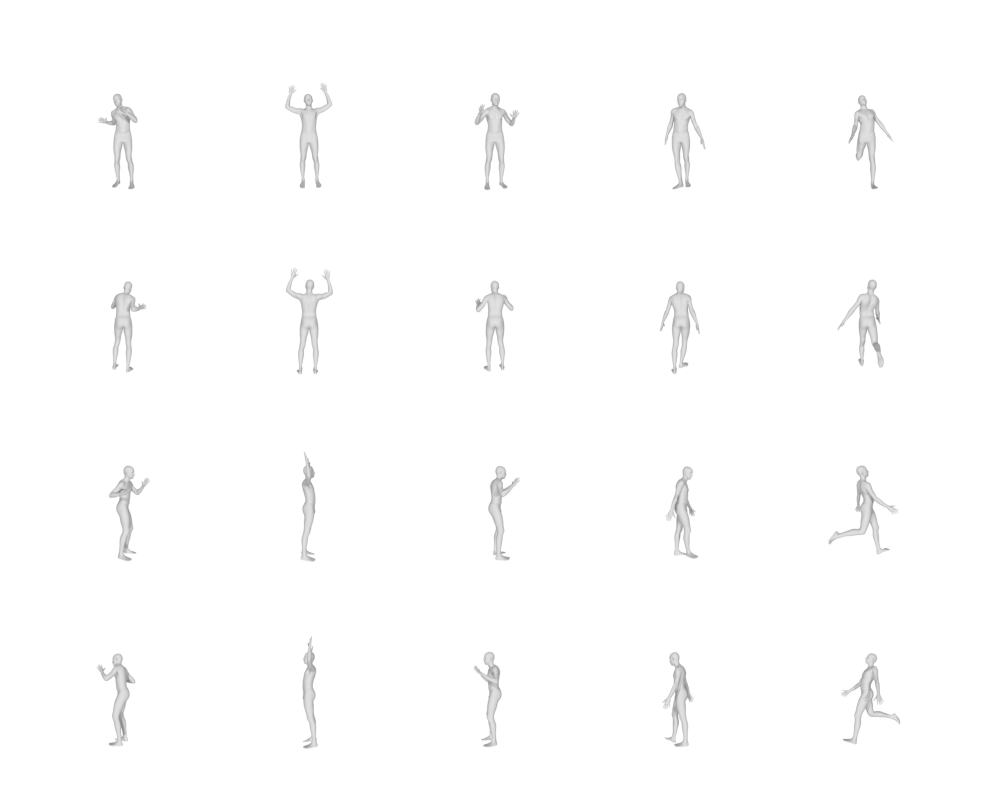

In [12]:
img = imagearray2file(images)
show_image(np.array(img)[0])

In the above image each column is a data point and at each row we rotate the body to visualize it from different angles.
AMASS has been recently used to train a human body prior for advanced human body inverse kinematics.
Take a look at the paper [Expressive Body Capture: 3D Hands, Face, and Body from a Single Image](https://smpl-x.is.tue.mpg.de/)
and the [VPoser](https://github.com/nghorbani/human_body_prior)  GitHub page for further information.
VPoser is capable of generating new body poses for SMPL body model.